## Q1. Median Maintenance using a Heap


### Part 1

Implement a "dominant heap" class `BinaryHeap`, which can handle both the min heap and the max heap cases, by having the constructor explicitly pass the "comparison" operator in. Replace min and del_min by dominant and del_dominant methods. Change the classmethod to also take in the operator.

In [39]:
#your code here
import subprocess
class BinaryHeap:
    def __init__(self, oper):
        self.storage=[None]
        self.upto=0
        self.oper = oper
        
    @classmethod
    def heapify_slow(cls, it, oper):
        inst = cls(oper)
        for i in it:
            inst.insert(i)
        return inst
            
    def insert(self, value):
        self.storage.append(value)
        self.upto += 1
        self.sift_up(self.upto)

    def sift_up(self, i):
        parent = i // 2
        if parent > 0 and self.oper(self.storage[i], self.storage[parent]):
            self.storage[i], self.storage[parent] = self.storage[parent], self.storage[i]
            self.sift_up(parent)
     
    def _min_child(self, i):
        if 2*i + 1 > self.upto:
            return 2*i
        else:
            l = (self.storage[2*i], self.storage[2*i+1])
            if self.oper is gt:
                return 2*i + l.index(max(l))
            else:
                return 2*i + l.index(min(l))
        
    
    def dotify(self, l, fname):
        start = """
        digraph G {
        nodesep=0.3;
        ranksep=0.2;
        margin=0.1;
        node [shape=circle];
        edge [arrowsize=0.8];
        """
        end = "}"
        labels=dict(enumerate(l))
        for i, v in labels.items():
            if i!=0 and 2*i < len(l):
                line1 = "{} -> {}[side=left];\n".format(i, 2*i)
            else:
                line1=""
            if i!=0 and 2*i + 1 < len(l):
                line2 = "{} -> {};\n".format(i, 2*i+1)
            else:
                line2 = ""
            start = start + line1 + line2
        end = "\n".join("{}[label=\"{}\"]".format(i, labels[i]) for i in labels if i!=0) + end
        with open(fname+".dot","w") as fd:
            fd.write(start+end)
        subprocess.call(['./treeplot.sh', fname])
        
    def sift_down(self, i):
        self.dotify(self.storage, "delimg"+str(i).zfill(2))
        if 2*i <= self.upto:
            child = self._min_child(i)
            if self.oper(self.storage[child],self.storage[i]):
                self.storage[child], self.storage[i] = self.storage[i], self.storage[child]
                self.sift_down(child)
        
    def dominant(self):
        return self.storage[1]
    
    def del_dominant(self):
        dominant_val = self.storage[1]
        self.storage[1], self.storage[self.upto] = self.storage[self.upto], self.storage[1]
        self.storage.pop()
        self.upto -= 1
        self.sift_down(1)
        return dominant_val

In [40]:
data = [1,8,5,9,23,2,45,6,7,99,-5]

In [41]:
from operator import gt, lt
bh = BinaryHeap.heapify_slow(data, lt)
print(bh.storage)
bh.dominant()
bh.del_dominant()
bh.del_dominant()
bh.del_dominant()
print(bh.storage)

[None, -5, 1, 2, 7, 6, 5, 45, 9, 8, 99, 23]
[None, 5, 6, 8, 7, 23, 99, 45, 9]


In [42]:
bh = BinaryHeap.heapify_slow(data, gt)
print(bh.storage)
bh.dominant()
bh.del_dominant()
bh.del_dominant()
print(bh.storage)

[None, 99, 45, 23, 7, 9, 2, 5, 1, 6, 8, -5]
[None, 23, 9, 5, 7, 8, 2, -5, 1, 6]


### Part 2

Median maintenance is a very cool algorithm to find an online median.
We create two arrays to test our implementation, using np.median to test our answer...

In [5]:
import random
import numpy as np
l = [random.randint(1,1000) for _ in range(150)]
print(len(l), np.median(l))
l2 = l + [random.randint(1,1000)]
print(len(l2), np.median(l2))

150 483.0
151 472.0


You will implement 'def online_median(iterator)' which is a generator yielding successive values of your online median.

The algorithm is as follows:

We'll use 2 heaps, a max heap for the lower half of the data, and a min-heap for the upper half. **We take the first 2values in our data and assign the smaller value to the max heap, while the larger value goes to the min-heap**. Then, as we "insert" subsequent values in one of the two heaps, the following holds: if we keep the number of elements in both heaps equal (for the even case) or at-most differing by one, the median is respectively the average of the two dominants or the dominant in the heap with one extra item.

What then is our strategy for this balanced insertion? Quite simple really: if a new value is not as dominant as the dominant value, add it to that heap. If it is more dominant, add it to the other. If two items in a row get added to the same heap, the heaps will be out of balance by more than one. In this case, take the dominant element from the larger heap and simply add it to the smaller one.

In [43]:
#your code here
def online_median(iterator):
    val1 = next(iterator)
    val2 = next(iterator)
    bh_max = BinaryHeap(gt)
    bh_min = BinaryHeap(lt)
    #which_heap = ''
    if val1 <= val2: 
        bh_max.insert(val1)
        yield val1
        bh_min.insert(val2)
        yield (val1+val2)/2
    else:
        bh_max.insert(val2)
        yield val2
        bh_min.insert(val1)
        yield (val1+val2)/2
    
    value = next(iterator)
    #value_next = next(iterator)
    #print (value,value_next)
    while True:
        which_heap = ''
        if value <= bh_max.dominant():
            bh_max.insert(value)
            yield check_length(bh_max, bh_min)
            which_heap = 'bh_max'
        else:
            bh_min.insert(value)
            yield check_length(bh_max, bh_min)
            which_heap = 'bh_min'
            
        try:
            value_next = next(iterator)
        except StopIteration:
            break
            
        if value_next <= bh_max.dominant():
            bh_max.insert(value_next)
            if 'bh_max' == which_heap:
                dominant_val = bh_max.del_dominant()
                bh_min.insert(dominant_val)
                yield check_length(bh_max, bh_min)
        else:
            bh_min.insert(value_next)
            if 'bh_min' == which_heap:
                dominant_val = bh_min.del_dominant()
                bh_max.insert(dominant_val)
                yield check_length(bh_max, bh_min)
                
        #value = value_next
        try:
            value = next(iterator)
        except StopIteration:
            break
        
    
def check_length(bh_max, bh_min):
    if len(bh_max.storage) == len(bh_min.storage):
        return (bh_max.dominant()+ bh_min.dominant())/2
    elif len(bh_max.storage) > len(bh_min.storage):
        return bh_max.dominant()
    else:
        return bh_min.dominant()

In [47]:
#l3 = [1,5,4,3,2,6]
#online_median(iter(l3))
#for i in online_median(iter(l3)):
#    print (i)

In [48]:
#l3 = [random.randint(1,1000) for _ in range(5)]
#print (l3)
#print(len(l3), np.median(l3))
#medians = list(online_median(iter(l3)))
#print (medians)
#for i in online_median(iter(l3)):
#    print (i)

Do your answers match?


483.0


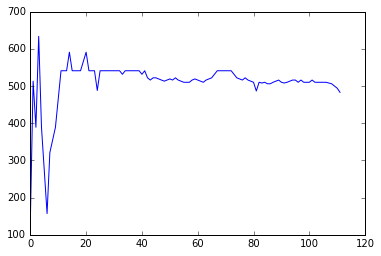

In [49]:
%matplotlib inline
import matplotlib.pyplot as plt

medians = list(online_median(iter(l)))
print(medians[-1])
plt.plot(medians)

In [50]:
list(online_median(iter(l2)))[-1]

472

Lastly, lets repeat the analysis we did last time on the randomly generated data.

In [51]:
from random import normalvariate, random
from itertools import count
def make_data(m, stop=None):
    for _ in count():
        if stop and _ > stop:
            break
        yield 1.0e09 + normalvariate(0, m*random() )

In [52]:
g = online_median(make_data(5, 100))
print(type(g))
out = list(g)
out[-10:]

<class 'generator'>


[999999999.6779938,
 999999999.674503,
 999999999.6779938,
 999999999.7047594,
 999999999.7315251,
 999999999.6779938,
 999999999.674503,
 999999999.6710122,
 999999999.6575899,
 999999999.6710122]

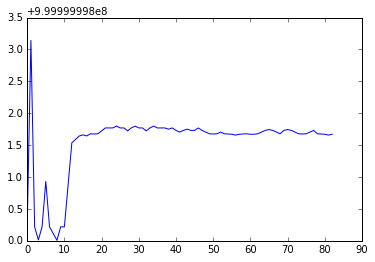

In [53]:
plt.plot(out)

## Q2

### Simulating a flight check-in counter

It is your job to simulate a flight-checkin counter. There are m agents handling n passengers. The passengers arrive in line with in-between time given by an exponential distribution for **INTER_ARRIVAL_TIME**. Each passenger, once he or she gets to a counter, is processed in a time drawn from an exponential distribution with **PROCESSING_TIME**. 

Clearly, in the usual case of 3-4 agents and 200+ customers on a flight, the customer waits much longer. We have been hired by the airlines customer-relations group to see how many extra agents must we hire to reduce waiting times by how much.

We start by representing each customer by a co-routine, which starts with the `inline` event. The state changes to the `atcounter` event, and then `ptime` seconds later, to the `leaves` event. Notice how this customer "process" is stopped at the yield, until the customer can be handled.

In [14]:
import collections, random
Event = collections.namedtuple('Event', 'time cid action agent')
def customer_process(idee, start, ptime):
    t, agent = yield Event(start, idee, "inline", None)
    t, agent = yield Event(t, idee, "atcounter", agent)
    yield Event(t+ptime, idee, "leaves", agent)            

The following function simply implements the draw from the exponential distribution for a given customer:

In [15]:
def duration(arr_time, service_time):
    return random.expovariate(1./arr_time), random.expovariate(1./service_time)

Here is out main simulation class. you will be filling in parts of this class.

The constructor sets up the simulation. Three queues are created, one for agents that become free, one priority queue for events so that they can be processed in the order recieved, and a backlog for queue for those customers waiting in line because no agent was available.

We set up all the customers in the constructor, with two dictionaries, one to hold the co-routines, and one to hold time metadata which we shall use to figure the average waiting time.

The `run` method is where all the action happens and is the one you will edit.

In [16]:
import queue
import logging
class Simulator:
    def __init__(self, n_agents, n_customers, INTER_ARRIVAL_TIME =1., PROCESSING_TIME=3., DEBUG=False ): 
        #queues
        self.free_agents = queue.Queue()
        self.backlog = queue.Queue()
        self.events=queue.PriorityQueue()
        
        #save the arguments
        self.n_customers = n_customers
        self.n_agents = n_agents
        self.intertime=INTER_ARRIVAL_TIME
        self.proctime=PROCESSING_TIME
        
        #dictionaries to hold customer process
        self.customers={}
        self.customer_meta={}
        self.logger = logging.getLogger("sim")
        if DEBUG:
            self.logger.setLevel(logging.DEBUG)
        else:
            self.logger.setLevel(logging.WARNING)
            
        #on the free_agents queue, we put all the agents, and the time
        #they got free
        for i in range(n_agents):
            self.free_agents.put((i,0))
            
        #this tracks when each customer came in.          
        time_when_came=0.
        for j in range(n_customers):
            interarrtime, proctime = duration(self.intertime, self.proctime)
            time_when_came += interarrtime
            intuple = (j, time_when_came, proctime)
            c = customer_process(*intuple)
            self.logger.debug("Customer {}, arrived {}, will take {} at counter".format(*intuple))
            #add each customer to dictionaries
            self.customers[j]=c
            self.customer_meta[j]={'cid':j, 'start':time_when_came, 'finish':None}
        self.logger.debug("========ending init==============\n\n")
        self.max_time_when_came=time_when_came

    def run(self, end_time):
        #we prime each customer co-routine at the start
        #and put that event in the events priority queue
        #Since an event is a tuple, the ordering will be by start time
        for cid, proc in sorted(self.customers.items()):
            first_event = next(proc)#prime
            self.events.put(first_event)#customer in line

        #start at time 0
        sim_time = 0
        while sim_time < end_time:
            #we are done if no events and no backlog
            if self.events.empty() and self.backlog.empty(): 
                self.logger.debug('*** end of events and backlog***') 
                break
            #if we have agents available and a backlog
            #take customer from backlog queue. This is equivalent
            #to taking customers from line
            if not self.backlog.empty() and not self.free_agents.empty():
                "YOUR CODE HERE"
                #if at least one customer is waiting in line
                #and at least one agent is free
                #get the first event from the backlog queue
                current_event = self.backlog.get()
                
                #the sim time from this branch will be false
                #as we get the old time the person in the line showed up
            else: #get current event in all other cases
                #this ensures that leave events are processed thus
                #freeing up agents
                "YOUR CODE HERE"
                #situation one: at least one customer is waiting in line
                #and no agent is free
                #situation two: the waiting line is empty
                #and at least one agent is free
                #Then get the first event from the events priority queue
                current_event = self.events.get()
            
            sim_time, cid, action, agent = current_event
            #get the current customer process
            #cproc = self.customers[cid]  
            #if cid is not a key in the customers dictionary, raise an exception
            try:
                cproc = self.customers[cid]
            except Exception:
                print("Error!:", self.customers, cid)
            next_time = -1 
                
            if action=='leaves':
                self.logger.debug(">>>Customer {} leaves, agent {} free at {}".format(cid, agent, sim_time))
                #an agent gets free. Put the time they got free on queue
                #also update the metadata
                self.free_agents.put((agent, sim_time))
                self.customer_meta[cid]['finish']=sim_time
            elif action=='atcounter':
                self.logger.debug("Customer {} atcounter Agent {} at {}".format(cid, agent, sim_time))
                next_time = sim_time#processing time already in coroutine
            elif action=='inline':#the agent is None to start
                self.logger.debug('----------------------------------------------')
                self.logger.debug("Customer {}, arrived in line @ {}.".format(cid, sim_time))

                if self.free_agents.empty():
                    self.logger.debug("NO agents available, putting {} inline on backlog at {}".format(cid, sim_time))
                    "YOUR CODE HERE"
                    #if no agent is free, the customers need to wait in line
                    self.backlog.put(Event(sim_time, cid, "inline", None))
                else:
                    self.logger.debug("{} agents available to serve.".format(self.free_agents.qsize()))
                    "YOUR CODE HERE"
                    #if at least one agent is free, get the next available agent
                    (agent, t) = self.free_agents.get()
                    next_time = max(sim_time, t)
                    
                    #handle both situations
                    #of getting from backlog or regular. The time in
                    #next_time which you will send in message to co-routine
                    #below are different
                    self.logger.debug("Customer {} inline to be served by Agent {} at {}".format(cid, agent, next_time))
            #drive the co-routine by sending in time and agent, and getting
            #next event out. The event is put into the priority queue.
            if next_time != -1:
                try:
                    next_event = cproc.send((next_time, agent)) 
                except StopIteration:
                    del self.customers[cid] 
                else:
                    self.events.put(next_event)
                
    def compute_ptimes(self):
        ptimes=[]
        for j in range(self.n_customers):
            #print(j,self.customer_meta[j] )
            if self.customer_meta[j]['finish']!=None:
                ptimes.append(self.customer_meta[j]['finish'] - self.customer_meta[j]['start'])
        return ptimes

In [17]:
def sim_main(num_agents, num_customers, extratime=20., seed=None, debug=True):
    if seed is not None:
        random.seed(seed)
    sim = Simulator(num_agents, num_customers, DEBUG=debug)
    sim.run(sim.max_time_when_came+extratime)
    return sim

Start small to test this out.

In [18]:
sim=sim_main(2,6, debug=True)
#print (sim)

Now lets try it with some larger numbers.

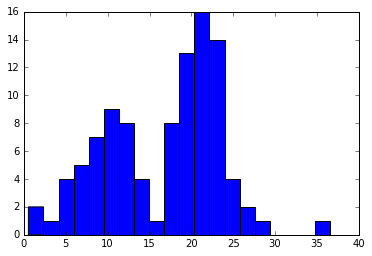

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt
sim=sim_main(3,100)
plt.hist(sim.compute_ptimes(), bins=20);

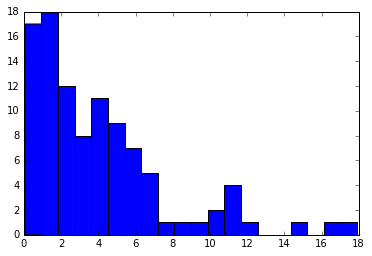

In [20]:
sim2=sim_main(4,100)
plt.hist(sim2.compute_ptimes(), bins=20);

extra time needed below as with 400 passengers a long time is taken to process.

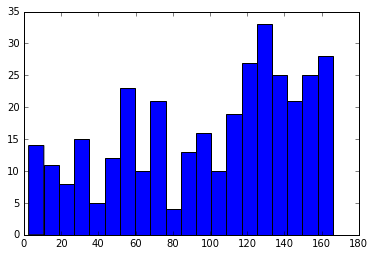

In [21]:
sim2=sim_main(2,400, extratime=100)
plt.hist(sim2.compute_ptimes(), bins=20);

For a proper statistical analysis, you would want to draw this multiple times and look at the distribution of the averages as well. But you should know what this distribution is :-).